<a href="https://colab.research.google.com/github/Kufzuk2/Cache/blob/master/sem4_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

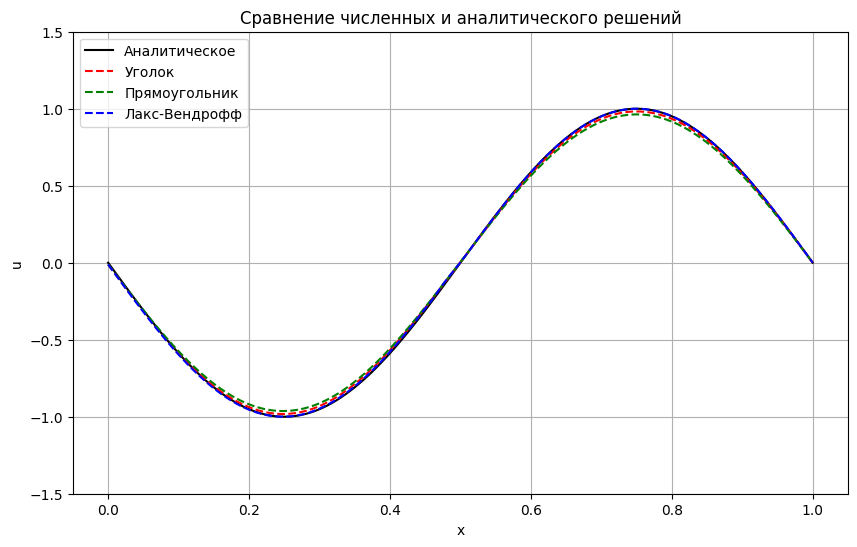

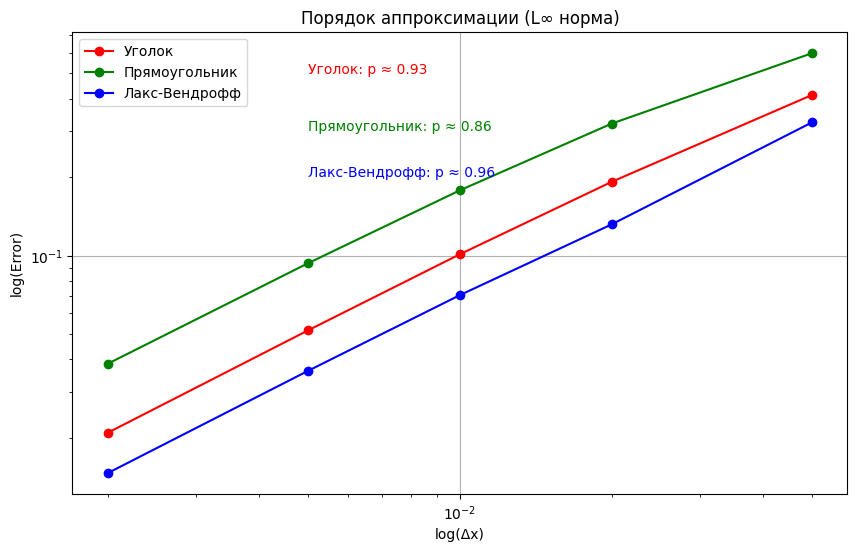

Порядок аппроксимации:
Уголок: 0.93
Прямоугольник: 0.86
Лакс-Вендрофф: 0.96


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# Создаем директорию для данных
if not os.path.exists("transport_data"):
    os.makedirs("transport_data")

# Параметры задачи
c = 1.0  # Скорость переноса
L = 1.0  # Длина области
T = 0.5  # Время интегрирования
courant = 0.1  # Число Куранта для устойчивости
nx = 500  # Количество узлов

# Аналитическое решение
def analytical_solution(x, t):
    return np.sin(2 * np.pi * (x - c * t))

# Схема "Уголок" (Upwind)
def upwind_scheme(nx, dt, dx, x):
    u = np.sin(2 * np.pi * x)  # Начальное условие
    u_new = np.zeros(nx)
    nt = int(T / dt) + 1
    r = c * dt / dx
    for n in range(nt):
        u_new[0] = u[0] - r * (u[0] - u[-1])  # Периодическое граничное условие
        for i in range(1, nx):
            u_new[i] = u[i] - r * (u[i] - u[i-1])
        u[:] = u_new[:]
    return u

# Схема "Прямоугольник" (FTCS с искусственной вязкостью)
def ftcs_scheme(nx, dt, dx, x):
    u = np.sin(2 * np.pi * x)  # Начальное условие
    u_new = np.zeros(nx)
    nt = int(T / dt) + 1
    r = c * dt / (2 * dx)
    epsilon = 0.1  # Коэффициент вязкости
    for n in range(nt):
        u_new[0] = u[0] - r * (u[1] - u[-1]) + epsilon * (u[1] - 2*u[0] + u[-1])
        for i in range(1, nx-1):
            u_new[i] = u[i] - r * (u[i+1] - u[i-1]) + epsilon * (u[i+1] - 2*u[i] + u[i-1])
        u_new[-1] = u[-1] - r * (u[0] - u[-2]) + epsilon * (u[0] - 2*u[-1] + u[-2])
        u[:] = u_new[:]
    return u

# Схема Лакс-Вендрофф
def lax_wendroff_scheme(nx, dt, dx, x):
    u = np.sin(2 * np.pi * x)  # Начальное условие
    u_new = np.zeros(nx)
    nt = int(T / dt) + 1
    r = c * dt / (2 * dx)
    r2 = (c * dt / dx)**2 / 2
    for n in range(nt):
        u_new[0] = u[0] - r * (u[1] - u[-1]) + r2 * (u[1] - 2*u[0] + u[-1])
        for i in range(1, nx-1):
            u_new[i] = u[i] - r * (u[i+1] - u[i-1]) + r2 * (u[i+1] - 2*u[i] + u[i-1])
        u_new[-1] = u[-1] - r * (u[0] - u[-2]) + r2 * (u[0] - 2*u[-1] + u[-2])
        u[:] = u_new[:]
    return u

# Сравнение решений и визуализация
dx = L / (nx - 1)
dt = courant * dx / c
x = np.linspace(0, L, nx)

# Вычисляем численные решения
u_analytic = analytical_solution(x, T)
u_upwind = upwind_scheme(nx, dt, dx, x)
u_ftcs = ftcs_scheme(nx, dt, dx, x)
u_lax = lax_wendroff_scheme(nx, dt, dx, x)

# Сохраняем данные
with open("transport_data/solutions_silent.csv", "w") as f:
    f.write("x,u_analytic,u_upwind,u_ftcs,u_lax\n")
    for xi, ua, uu, uf, ul in zip(x, u_analytic, u_upwind, u_ftcs, u_lax):
        f.write(f"{xi},{ua},{uu},{uf},{ul}\n")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, u_analytic, 'k-', label='Аналитическое')
plt.plot(x, u_upwind, 'r--', label='Уголок')
plt.plot(x, u_ftcs, 'g--', label='Прямоугольник')
plt.plot(x, u_lax, 'b--', label='Лакс-Вендрофф')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Сравнение численных и аналитического решений')
plt.legend()
plt.grid(True)
plt.ylim(-1.5, 1.5)  # Ограничиваем масштаб
plt.savefig("transport_data/solutions_comparison_silent.png")
plt.show()

# Исследование сходимости и порядка аппроксимации
dx_values = [0.05, 0.02, 0.01, 0.005, 0.002]
errors_upwind = []
errors_ftcs = []
errors_lax = []

for dx in dx_values:
    nx = int(L / dx) + 1
    x = np.linspace(0, L, nx)
    dt = courant * dx / c
    u_analytic = analytical_solution(x, T)
    u_upwind = upwind_scheme(nx, dt, dx, x)
    u_ftcs = ftcs_scheme(nx, dt, dx, x)
    u_lax = lax_wendroff_scheme(nx, dt, dx, x)
    errors_upwind.append(np.max(np.abs(u_upwind - u_analytic)))
    errors_ftcs.append(np.max(np.abs(u_ftcs - u_analytic)))
    errors_lax.append(np.max(np.abs(u_lax - u_analytic)))

# Сохраняем данные ошибок
with open("transport_data/convergence_silent.csv", "w") as f:
    f.write("dx,err_upwind,err_ftcs,err_lax\n")
    for dx, eu, ef, el in zip(dx_values, errors_upwind, errors_ftcs, errors_lax):
        f.write(f"{dx},{eu},{ef},{el}\n")

# График порядка аппроксимации
plt.figure(figsize=(10, 6))
plt.loglog(dx_values, errors_upwind, 'r-o', label='Уголок')
plt.loglog(dx_values, errors_ftcs, 'g-o', label='Прямоугольник')
plt.loglog(dx_values, errors_lax, 'b-o', label='Лакс-Вендрофф')
plt.xlabel('log(Δx)')
plt.ylabel('log(Error)')
plt.title('Порядок аппроксимации (L∞ норма)')
plt.grid(True)
plt.legend()

# Оценка порядка аппроксимации
p_upwind = np.polyfit(np.log(dx_values), np.log(errors_upwind), 1)[0]
p_ftcs = np.polyfit(np.log(dx_values), np.log(errors_ftcs), 1)[0]
p_lax = np.polyfit(np.log(dx_values), np.log(errors_lax), 1)[0]
plt.text(0.005, 0.5, f'Уголок: p ≈ {p_upwind:.2f}', color='red')
plt.text(0.005, 0.3, f'Прямоугольник: p ≈ {p_ftcs:.2f}', color='green')
plt.text(0.005, 0.2, f'Лакс-Вендрофф: p ≈ {p_lax:.2f}', color='blue')

plt.savefig("transport_data/convergence_order_silent.png")
plt.show()

# Вывод результатов
print(f"Порядок аппроксимации:")
print(f"Уголок: {p_upwind:.2f}")
print(f"Прямоугольник: {p_ftcs:.2f}")
print(f"Лакс-Вендрофф: {p_lax:.2f}")